# Implementing Non-negative Matrix Factorization for Topic Modeling
In this notebook, we implement an NMF algorithm to learn topics from New York Times articles.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# New York Times Articles
The data consists of $8447$ documents from *The New York Times* resulting in a corpus with a $3012$ word vocabulary. Each row in the text file corresponds to a single document that gives the index of words appearing in that document and the number of times they appear in the format
```
idx:count
```
with commas separating each unique word in the document. Any index that doesn't appear in a row has a count of zero for that word.

In [4]:
with open('data/nyt-data.txt', 'rt') as f:
    nyt_data = f.readlines()

print(nyt_data[0])

1946:2,1168:2,1194:2,1275:1,777:1,522:1,107:1,839:2,424:2,2330:2,1878:2,344:1,1008:1,94:3,735:1,212:1,2407:1,2623:1,781:2,42:1,160:1,1141:1,117:1,16:1,108:1,153:2,1137:2,416:1,23:2,46:1,734:2,284:1,207:2,301:1,357:1,780:2,2564:2,206:1,106:2,892:1,272:1,1557:1,2003:1,1079:2,370:1,1894:2,266:1,143:1,1532:1,2551:1,223:2,30:1,1509:1,1921:2,361:2,311:1,1549:2,203:1,2821:1,546:2,1612:1,200:1,247:2,1731:2,565:1,2253:1,234:1,72:1,648:1,1072:1,518:1,39:1,703:2,625:1,140:1,2301:1,32:1,462:1,743:1,2017:2,925:1,118:1,1000:2,836:1,161:1,942:2,885:1,267:1,2683:1,626:1,317:1,69:1,860:2,633:1,2658:1,75:2,1563:1,690:1,802:1,1650:1,1836:1,111:1,2151:1,128:2,2864:1,22:2,1301:1,250:2,1922:2,936:1,918:1,775:1,280:1,18:2,182:1,667:1,2383:1,878:1,1498:1,109:2,1577:1,1758:1,60:1,2269:1,215:1,2038:2,485:1,335:1,2543:2,422:1,12:1,585:2,1754:1,1293:1,604:1,52:1,248:1,2:2,603:2,1345:2,271:3,668:1,1022:2,260:1,1251:2,498:1,2213:1,351:3,2584:1,1349:1,334:2,218:1,34:1,256:1,2576:2,58:1,1637:1,926:2,313:1,2041:2,1505

# Generating the Bag of Words Matrix
Each document is converted into a $3012$-dimensional column vector, which when concatenated with other document vectors, results in a matrix $X \in \mathbb{R}^{3012 \times 8447}$ where $X_{ij}$ is the number of times word $i$ appears in document $j$.

In [19]:
n_documents = len(nyt_data)
n_words = 3012
X = np.zeros([n_words, n_documents])
for j, document in enumerate(nyt_data):
    document = [[int(element) for element in pair.split(':')] for pair in document.split(',')]
    for pair in document:
        i = pair[0] - 1 # force 0-indexing
        count = pair[1]
        X[i,j] = count

# Non-negative Matrix Factorization with Divergence Penalty
In factorizing the matrix $X=WH$ where $W\in\mathbb{R}^{3012\times k}$ and $H\in\mathbb{R}^{k \times 8447}$, we can think of each rolumn of $R$ as a distribution on words that defines a **topic**. For example, if a particular distribution weights words such as "Republican", "Democrat", "President", and "election" highly, we might consider such a distribution a "politics" topic. We can similarly think of each column of $H$ as a document's distribution on topics, so documents with a higher weighting for "politics" would contain more words such as "Republican", "Democrat", etc.

We want to minimize the divergence loss:
$$D(X||WH) = \sum_{i=1}^{3012}\sum_{j=1}^{8447}[X_{ij}\ln\frac{1}{(WH)_{ij}}+(WH)_{ij}]$$
subject to all values in $W$ and $H$ being non-negative.

To do so, we first randomly initialize $W$ and $H$ to non-negative values, in this case from the Uniform(1,2) distribution, then iterate the following until the change in loss is sufficiently small:
- $H_{kj} \leftarrow H_{kj} \frac{\sum_{i}W_{ik}X_{ij}/(WH)_{ij}}{\sum_{i}W_{ij}}$


- $W_{ik} \leftarrow W_{ik} \frac{\sum_j H_{kj}X_{ij}/(WH)_{ij}}{\sum_j H_{kj}}$

In [91]:
class NMF():
    
    def __init__(self, n_components=25, n_iter=100):
        self.n_components = n_components
        self.n_iter = n_iter
        self.losses = list()
        
    def calculate_loss(self, X):
        X_prime = self.W.dot(self.H) + 1e-15
        loss = np.sum(-X * np.log(X_prime) - X_prime)
        return loss
        
    def fit(self, X, y=None):
        n_words = X.shape[0]
        n_documents = X.shape[1]
        n_components = self.n_components
        self.W = np.random.uniform(1, 2, [n_words, n_components])
        self.H = np.random.uniform(1, 2, [n_components, n_documents])
        
        for i in range(self.n_iter):
            Z = (X / (self.W.dot(self.H) + 1e-15))
            W_transpose_normed = self.W.T / \
                (self.W.T.sum(axis = 1, keepdims=True) + 0)
            self.H *= W_transpose_normed.dot(Z)
            
            Z = (X / (self.W.dot(self.H) + 1e-15))
            H_transpose_normed = self.H.T / \
                (self.H.T.sum(axis = 0, keepdims=True) + 0)
            self.W *= Z.dot(H_transpose_normed)
            
            self.losses.append(self.calculate_loss(X))
            
        return self
    
    def transform(self):
        return self.W

We run the NMF algorithm on the *New York Times* data setting the number of topics to $25$ and number of iterations to $100$.

In [92]:
nmf = NMF(n_iter=100)
nmf.fit(X)

Below, we plot the divergence loss as a function of iteration.

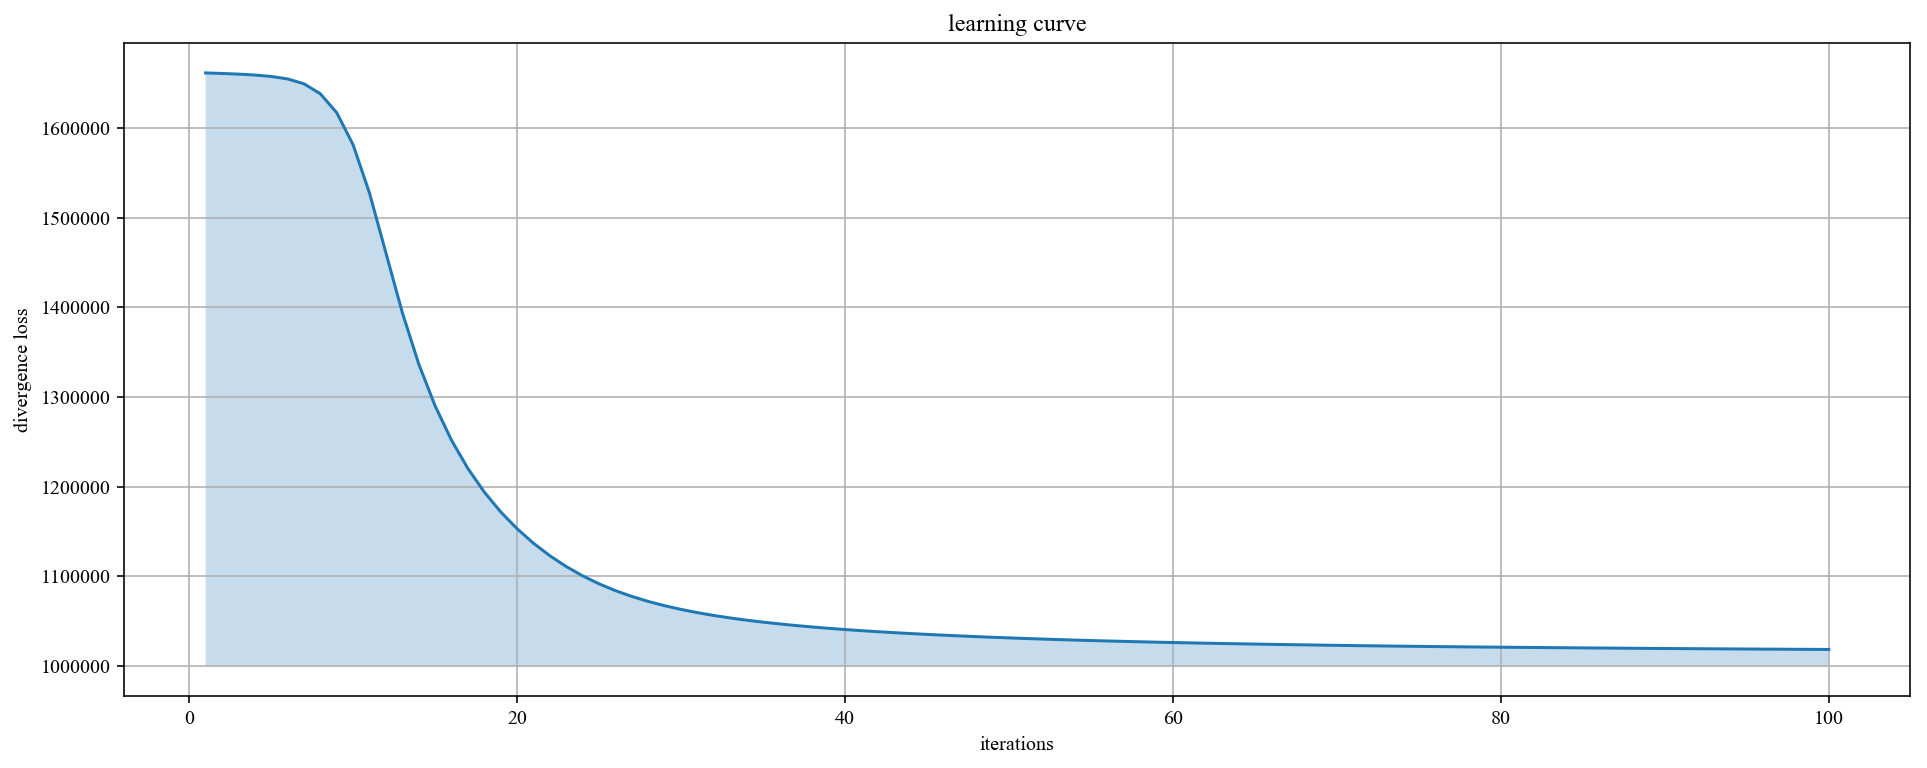

In [103]:
plt.figure(figsize = (16,6))
plt.plot(range(1, len(nmf.losses)+1), nmf.losses)
plt.fill_between(range(1, len(nmf.losses)+1), 1000000, nmf.losses, alpha=0.25)
ax = plt.gca()
ax.set(title='learning curve',
       xlabel='iterations',
       ylabel='divergence loss')
ax.grid(True)

# Displaying Topics
We then normalize the columns of $W$ so they sum to one (i.e. represent valid probability distributions).

In [113]:
with open('data/nyt-vocab.dat', 'rb') as f:
    nyt_vocab = f.readlines()
    
nyt_vocab = np.array([word.decode().strip() for word in nyt_vocab])

topics = nmf.W / nmf.W.sum(axis = 0, keepdims=True)
top_words = np.argsort(-topics, axis = 0)[:25,:]
top_weights = -np.sort(-topics, axis = 0)[:25,:]

 For each column of $W$, we list the $10$ words having the largest weight and their corresponding weights.

In [171]:
for i in range(1,6):
    for j in range(1,6):
        col = j + (i-1) * 5
        print('{:=^22}'.format(' topic {} '.format(col)), end = ' ')
    
    print()
    for k in range(0, 10):
        for j in range(1,6):
            col = j + (i-1) * 5 - 1
            word = nyt_vocab[top_words[k, col]]
            weight = top_weights[k, col]
            print('{:<22}'.format(' {:<13} {:>4}'.format(word, np.round(weight, 4))),
                  end='|')
        print()
    
    print()

====== topic 1 ======= ====== topic 2 ======= ====== topic 3 ======= ====== topic 4 ======= ====== topic 5 ======= 
 food          0.0154 | computer      0.0183 | season        0.0206 | team          0.0384 | win           0.0372 |
 restaurant    0.0095 | company       0.0165 | game          0.02   | game          0.0365 | second        0.0323 |
 serve         0.0093 | information   0.0124 | baseball      0.0195 | player        0.0267 | third         0.0226 |
 taste         0.0078 | product       0.0116 | contract      0.0172 | play          0.0262 | victory       0.0192 |
 dry           0.0077 | technology    0.0115 | team          0.0171 | season        0.0217 | score         0.0176 |
 eat           0.0077 | customer      0.0114 | manager       0.015  | coach         0.019  | final         0.0149 |
 fresh         0.0075 | sell          0.0102 | hit           0.0148 | pass          0.0103 | finish        0.0139 |
 add           0.0071 | service       0.01   | pitch         0.014  | fo